<h1 align="left">
  <picture>
    <source media="(prefers-color-scheme: dark)" srcset="../assets/logo/123D_logo_transparent_white.svg" width="750">
    <source media="(prefers-color-scheme: light)" srcset="../assets/logo/123D_logo_transparent_black.svg" width="750">
    <img alt="Logo" src="assets/logo/123D_logo_transparent_black.svg" width="1000">
  </picture>
  <h2 align="left">123D: Map Tutorial</h1>
</h1>

In [1]:
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np

from py123d.api import MapAPI, SceneAPI, SceneFilter
from py123d.api.scene.arrow.arrow_scene_builder import ArrowSceneBuilder
from py123d.common.multithreading.worker_parallel import SingleMachineParallelExecutor
from py123d.datatypes.map_objects import (
    BaseMapLineObject,
    BaseMapObject,
    BaseMapSurfaceObject,
    Intersection,
    Lane,
    LaneGroup,
    MapLayer,
    RoadEdgeType,
    RoadLineType,
)
from py123d.geometry import Point3D, Polyline2D
from py123d.visualization.color.default import MAP_SURFACE_CONFIG
from py123d.visualization.matplotlib.utils import add_non_repeating_legend_to_ax

# Set some default visualization parameters
DEFAULT_FIGSIZE = (9, 9)
SURFACE_ALPHA = 0.3

Dataset paths not set. Using default config: /home/daniel/py123d_workspace/py123d/src/py123d/script/config/common/default_dataset_paths.yaml


## 2.1 Download Demo Logs

In [2]:
# TODO

## 2.2 Create Scenes by filtering the datasets

We create some scenes for easy access to some `MapAPI`'s. We use the option `map_api_required=True` to only include scenes/logs with maps.

In [3]:
scene_filter = SceneFilter(
    split_names=None,
    duration_s=None,  # No duration means that the scene will include the complete log.
    shuffle=True,
    map_api_required=True,  # Only include scenes/logs with an available map API.
)
worker = SingleMachineParallelExecutor()

# worker = RayDistributed()
scenes = ArrowSceneBuilder().get_scenes(scene_filter, worker)
print(f"Found {len(scenes)} scenes.")

Found 74 scenes.


## 2.3 Inspecting the `MapAPI`


`MapMetadata`: If the map is available, this object includes information about the location, whether the map is 3D (`map_has_z`), of the the map is defined per log (`map_is_local`).

In [4]:
scene: SceneAPI = np.random.choice(scenes)
map_api: MapAPI = scene.get_map_api()

map_metadata = scene.map_metadata
map_metadata

MapMetadata(dataset='nuplan', split=None, log_name=None, location='us-nv-las-vegas-strip', map_has_z=False, map_is_local=False, version='0.0.8')

## 2.4 Querying map objects

There are multiple categories, also called layers, of map objects in 123D. You can get the available layers with:

In [5]:
map_api.get_available_map_layers()

[<MapLayer.LANE: 0>,
 <MapLayer.LANE_GROUP: 1>,
 <MapLayer.INTERSECTION: 2>,
 <MapLayer.CROSSWALK: 3>,
 <MapLayer.WALKWAY: 4>,
 <MapLayer.CARPARK: 5>,
 <MapLayer.GENERIC_DRIVABLE: 6>,
 <MapLayer.STOP_ZONE: 7>,
 <MapLayer.ROAD_EDGE: 8>,
 <MapLayer.ROAD_LINE: 9>]

These layers can be divided into:
- `BaseMapSurfaceObject`: Objects/layers that defined a surface , e.g. a polygon or triangle mesh. Examples are lanes, lane groups, crosswalks, etc.
- `BaseMapLineObject`: Objects/layers that define a polyline in the map, e.g. a road edge or road line.

All map objects are of type `BaseMapObject` which merely requires a `map_object_id` that is unique in each layer.

The features of a map object depend on the type. You can query map objects with several functions, e.g. given a query point and radius.

In [6]:
# You can define a query point and radius to search for map objects around that point.
query_point: Optional[Point3D] = None  # e.g. Point(x=0.0, y=0.0, z=0.0)
query_radius: float = 100.0  # meters

# Otherwise, we use the ego vehicle position, or the origin if no ego state is available.
if query_point is None:
    if (ego_state := scene.get_ego_state_at_iteration(iteration=0)) is not None:
        query_point = ego_state.center_se3.point_3d
    else:
        query_point = Point3D(0.0, 0.0, 0.0)


# For this example, we will query all available map layers.
map_layers = [
    MapLayer.LANE,  # Lanes (surface)
    MapLayer.LANE_GROUP,  # Lane groups (surface)
    MapLayer.INTERSECTION,  # Intersections (surface)
    MapLayer.CROSSWALK,  # Crosswalks (surface)
    MapLayer.WALKWAY,  # Walkways (surface)
    MapLayer.CARPARK,  # Carparks (surface)
    MapLayer.GENERIC_DRIVABLE,  # Generic drivable (surface)
    MapLayer.STOP_ZONE,  # Stop zones (surface)
    MapLayer.ROAD_EDGE,  # Road edges (lines)
    MapLayer.ROAD_LINE,  # Road lines (lines)
]

# Query map objects: returns a dictionary mapping each map layer to a list of map objects in that layer.
map_object_dict = map_api.get_map_objects_in_radius(point=query_point, radius=query_radius, layers=map_layers)

print(f"Map objects found in radius {query_radius} around point {query_point}:")
for map_layer, map_objects in map_object_dict.items():
    print(f"- {map_layer.name}: {len(map_objects)} objects")

Map objects found in radius 100.0 around point Point3D(x=664457.8851674196, y=3998094.9338303064, z=615.8749372468315):
- LANE: 87 objects
- LANE_GROUP: 29 objects
- INTERSECTION: 10 objects
- CROSSWALK: 3 objects
- WALKWAY: 4 objects
- CARPARK: 0 objects
- GENERIC_DRIVABLE: 0 objects
- STOP_ZONE: 0 objects
- ROAD_EDGE: 14 objects
- ROAD_LINE: 215 objects


Before we inspect the map objects, let's define some helper functions to visualize them.

In [7]:
def add_map_object_id(ax: plt.Axes, map_object: BaseMapObject) -> None:
    """Helper to add the map object ID as text at the centroid of the map object."""
    if isinstance(map_object, BaseMapSurfaceObject):
        centroid = map_object.shapely_polygon.centroid
    elif isinstance(map_object, BaseMapLineObject):
        centroid = map_object.polyline_2d.interpolate(0.5, normalized=True).shapely_point
    else:
        raise TypeError(f"Unsupported map object type of type {type(map_object)}.")

    ax.text(
        centroid.x,
        centroid.y,
        str(map_object.object_id),
        fontsize=8,
        ha="center",
        va="center",
        color="black",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.7),
    )


def add_map_surface_object(
    ax: plt.Axes,
    map_surface_object: BaseMapSurfaceObject,
    add_id: bool = True,
    alpha: float = SURFACE_ALPHA,
    **plot_kwargs,
) -> None:
    """Helper to plot a map surface object."""
    x, y = map_surface_object.shapely_polygon.exterior.xy
    ax.fill(x, y, alpha=alpha, **plot_kwargs)
    if add_id:
        add_map_object_id(ax, map_surface_object)


def add_map_line_object(ax: plt.Axes, map_line_object: BaseMapLineObject, add_id: bool = True, **plot_kwargs) -> None:
    """Helper to plot a map line object."""
    polyline_array = map_line_object.polyline_2d.array
    ax.plot(polyline_array[:, 0], polyline_array[:, 1], **plot_kwargs)
    if add_id:
        add_map_object_id(ax, map_line_object)


def add_polyline(ax: plt.Axes, polyline: Polyline2D, add_start_end: bool = False, **plot_kwargs) -> None:
    """Helper to plot a polyline."""
    polyline_array = polyline.array
    ax.plot(polyline_array[:, 0], polyline_array[:, 1], **plot_kwargs)
    if add_start_end:
        ax.plot(polyline.array[0, 0], polyline.array[0, 1], "o", label="Start", color="black")
        ax.plot(polyline.array[-1, 0], polyline.array[-1, 1], "x", label="End", color="black")


def adjust_aspect_custom(ax: plt.Axes) -> None:
    """Helper to adjust the aspect ratio of a matplotlib Axes."""
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    max_range = max(x_range, y_range)

    x_center = (x_limits[0] + x_limits[1]) / 2
    y_center = (y_limits[0] + y_limits[1]) / 2

    ax.set_xlim(x_center - max_range / 2, x_center + max_range / 2)
    ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)
    ax.set_aspect("equal", adjustable="box")

## 2.5 Map Objects in 123D

### 2.5.1 `Lane`

Let's start with the `Lane` object. Each lane can have multiple features, such as polylines from boundaries or the lane center, relational properties that point to neighboring map objects, or other features, such as the speed limit. 
We can sample a lane and have a look:

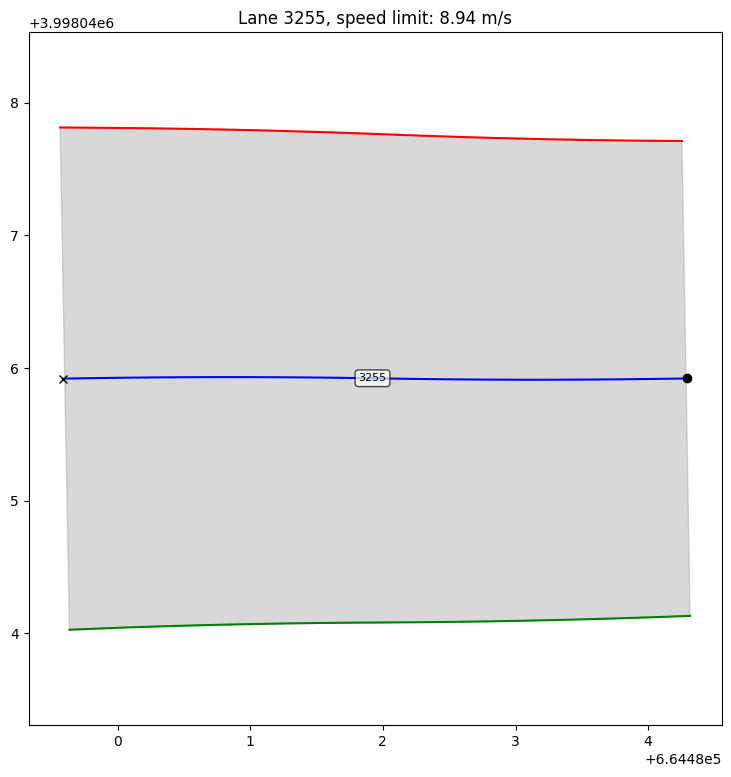

In [8]:
# Sample a random lane
if (lanes := map_object_dict[MapLayer.LANE]) is not None and len(lanes) > 0:
    lane: Lane = np.random.choice(lanes)

if lane is not None:
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    centerline = lane.centerline
    right_boundary = lane.right_boundary
    left_boundary = lane.left_boundary

    # Plot centerline and boundaries
    add_polyline(ax, centerline, label="Centerline", color="blue", add_start_end=True)
    add_polyline(ax, right_boundary, label="Right Boundary", color="red")
    add_polyline(ax, left_boundary, label="Left Boundary", color="green")

    # Plot lane surface
    add_map_surface_object(ax, lane, label="Surface", color="grey")

    speed_limit_mps = round(lane.speed_limit_mps, 2) if lane.speed_limit_mps is not None else "N/A"
    ax.set_title(f"Lane {lane.object_id}, speed limit: {speed_limit_mps} m/s")
    centroid = lane.shapely_polygon.centroid

    # Surface of the lane
    adjust_aspect_custom(ax)

plt.show()

Lanes can have neighbors, which can either be accessed as IDs or directly. These neighbors include:
- List of successor / predecessor lanes (`None` if not available)
- Single lane to the left or right (`None` if not available) 

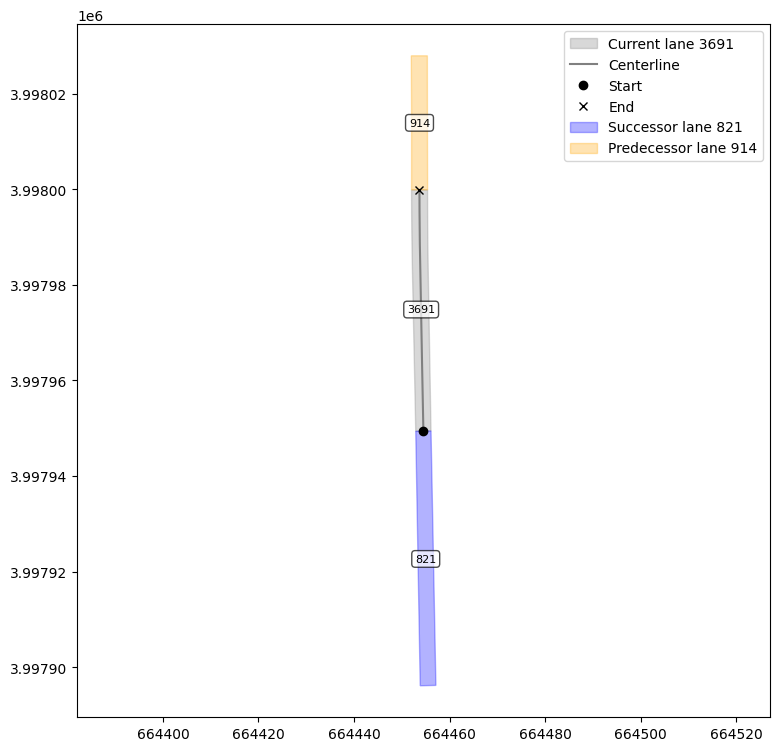

In [9]:
# Sample a random lane
if (lanes := map_object_dict[MapLayer.LANE]) is not None and len(lanes) > 0:
    lane: Lane = np.random.choice(lanes)

if lane is not None:
    size = (8, 8)

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    # Add the current lane:
    add_map_surface_object(ax, lane, label=f"Current lane {lane.object_id}", color="grey")
    add_polyline(ax, lane.centerline, label="Centerline", color="grey", add_start_end=True)

    # Add left neighbor lane:
    if lane.left_lane is not None:
        add_map_surface_object(ax, lane.left_lane, label=f"Left lane {lane.left_lane.object_id}", color="green")

    if lane.right_lane is not None:
        add_map_surface_object(ax, lane.right_lane, label=f"Right lane {lane.right_lane.object_id}", color="red")

    # Add successor lanes:
    for successor_lane in lane.successors:
        add_map_surface_object(ax, successor_lane, label=f"Successor lane {successor_lane.object_id}", color="blue")

    for predecessor in lane.predecessors:
        add_map_surface_object(ax, predecessor, label=f"Predecessor lane {predecessor.object_id}", color="orange")

    adjust_aspect_custom(ax)
    add_non_repeating_legend_to_ax(ax)

### 2.5.2 `LaneGroup`

A lane can be part of a lane group. Lane groups are sets of lanes that go in the same direction. The lane group can be accessed from the lane directly.

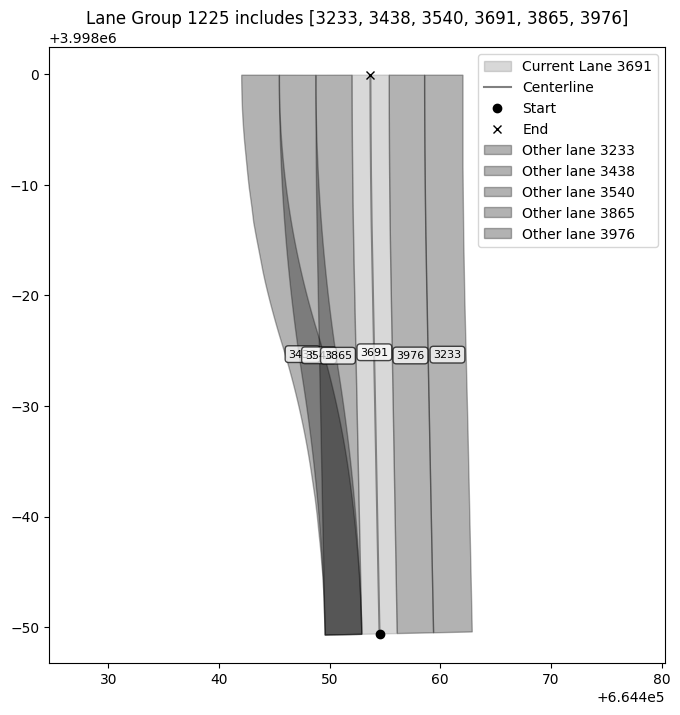

In [10]:
if lane is not None and lane.lane_group is not None:
    lane_group: LaneGroup = lane.lane_group

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(
        f"Lane Group {lane_group.object_id} includes [{', '.join(str(l.object_id) for l in lane_group.lanes)}]"
    )

    # Original lane
    add_map_surface_object(ax, lane, label=f"Current Lane {lane.object_id}", color="grey")
    add_polyline(ax, lane.centerline, label="Centerline", color="grey", add_start_end=True)

    # Other lanes in the lane group
    for group_lane in lane_group.lanes:
        if group_lane.object_id != lane.object_id:
            add_map_surface_object(ax, group_lane, label=f"Other lane {group_lane.object_id}", color="black")

    adjust_aspect_custom(ax)
    add_non_repeating_legend_to_ax(ax)

Lane groups are surfaces, with neighboring relationships. Let's sample another lane group and have a look:

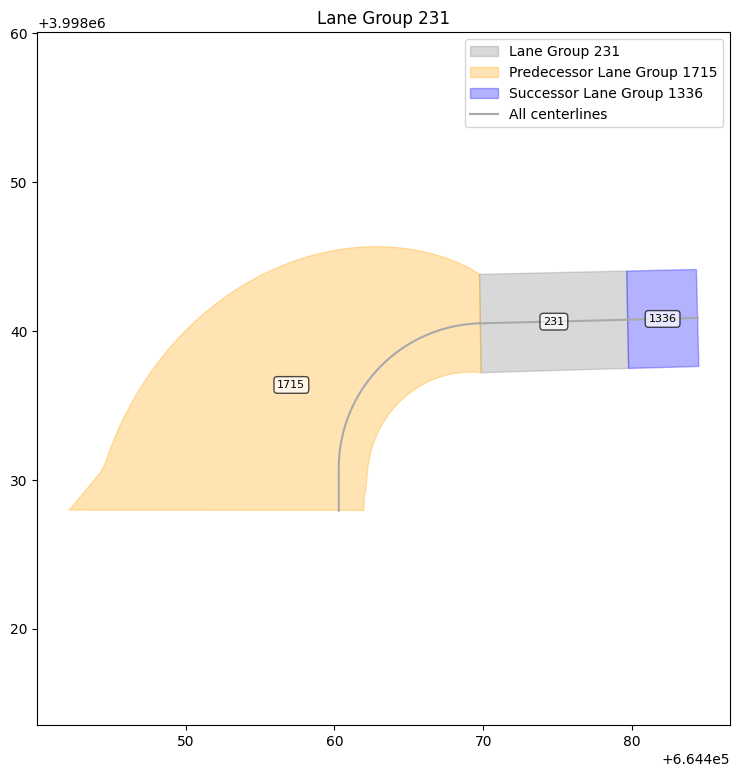

In [11]:
if len(map_object_dict[MapLayer.LANE_GROUP]) > 0:
    lane_group: LaneGroup = np.random.choice(map_object_dict[MapLayer.LANE_GROUP])

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.set_title(f"Lane Group {lane_group.object_id}")

    all_lanes: List[Lane] = lane_group.lanes

    # Current lane group
    add_map_surface_object(ax, lane_group, label=f"Lane Group {lane_group.object_id}", color="grey")

    # Predecessor lane groups
    for predecessor in lane_group.predecessors:
        add_map_surface_object(ax, predecessor, label=f"Predecessor Lane Group {predecessor.object_id}", color="orange")
        all_lanes += predecessor.lanes

    # Successor lane groups
    for successor in lane_group.successors:
        add_map_surface_object(ax, successor, label=f"Successor Lane Group {successor.object_id}", color="blue")
        all_lanes += successor.lanes

    # Adding all centerline
    for lane in all_lanes:
        centerline = lane.centerline
        ax.plot(*centerline.array.T[:2], label="All centerlines", color="darkgrey")

    adjust_aspect_custom(ax)
    add_non_repeating_legend_to_ax(ax)
plt.show()

### 2.5.3 `Intersection`

Intersections are map surfaces that include multiple lane groups. Let's look at a random example:

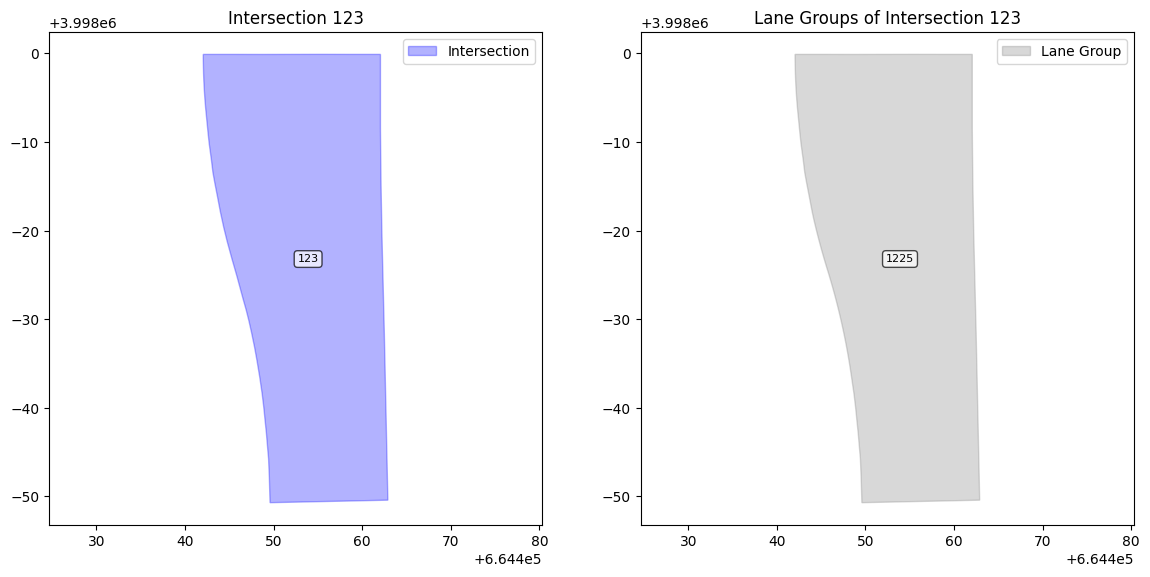

In [12]:
if len(map_object_dict[MapLayer.INTERSECTION]) > 0:
    intersection: Intersection = np.random.choice(map_object_dict[MapLayer.INTERSECTION])

    fig, ax = plt.subplots(ncols=2, figsize=(14, 7))
    ax[0].set_title(f"Intersection {intersection.object_id}")
    add_map_surface_object(ax[0], intersection, label="Intersection", color="blue")

    lane_groups: List[LaneGroup] = intersection.lane_groups
    ax[1].set_title(f"Lane Groups of Intersection {intersection.object_id}")
    for lane_group in lane_groups:
        add_map_surface_object(ax[1], lane_group, label="Lane Group", color="grey")

    for ax_ in ax:
        add_non_repeating_legend_to_ax(ax_)
        adjust_aspect_custom(ax_)

plt.show()

### 2.5.4 Other map surfaces

Besides lanes, lane groups, and intersection, the 123D map has a few simpler map surface objects. These include:

- `Crosswalk`
- `Walkway`
- `Carpark`
- `GenericDrivable`
- `StopZone`

The availability of these objects depend on the dataset. For now, we can just plot all objects we found in our previous query.

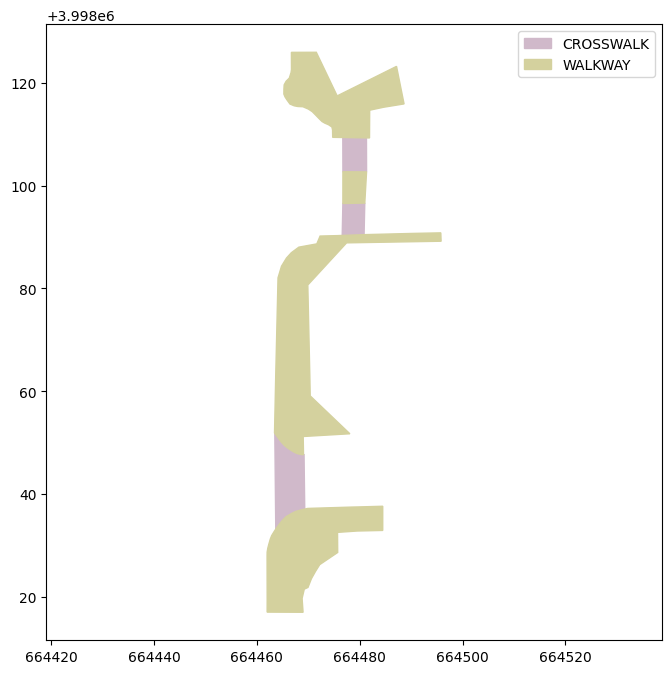

In [13]:
misc_map_surfaces: List[MapLayer] = [
    MapLayer.CROSSWALK,
    MapLayer.WALKWAY,
    MapLayer.CARPARK,
    MapLayer.GENERIC_DRIVABLE,
    MapLayer.STOP_ZONE,
]

size = 8
fig, ax = plt.subplots(figsize=(size, size))
for map_layer in misc_map_surfaces:
    map_surface_objects: List[BaseMapSurfaceObject] = map_object_dict[map_layer]

    # Here, we just use the default 123D colors for each map layer.
    map_layer_color = str(MAP_SURFACE_CONFIG[map_layer].fill_color)

    for map_surface_object in map_surface_objects:
        add_map_surface_object(
            ax,
            map_surface_object,
            label=f"{map_layer.name}",
            alpha=1.0,
            color=map_layer_color,
            add_id=False,
        )

adjust_aspect_custom(ax)
add_non_repeating_legend_to_ax(ax)
plt.show()

### 2.5.5 `RoadEdge`

In contrast to all previous road objects, we now have a look at map objects that are lines. 

Road edges are polylines (either in 2D or 3D) that mark the edge between drivable surfaces and non-drivable areas.
The concept of road edges is based on the [Waymo Open Datasets (Motion / Perception)](https://waymo.com/open/), where drivable areas are **not** represented by outlines or polygons.
While we have a method to convert the Waymo map to a more polygon-based representation, this conversion method cannot fully recover the drivable area.

Therefore, we added road edges to the 123D map. The road edges of non-Waymo maps are extracted from the 3D/2D surfaces of the maps. 





Road edges have a `RoadEdgeType`, which is one of:

In [14]:
for road_edege_type in RoadEdgeType:
    print(f"- {road_edege_type}")

- RoadEdgeType.UNKNOWN
- RoadEdgeType.ROAD_EDGE_BOUNDARY
- RoadEdgeType.ROAD_EDGE_MEDIAN


We will plot some road edges from our previous query. We will also add other drivable surfaces as polygons.

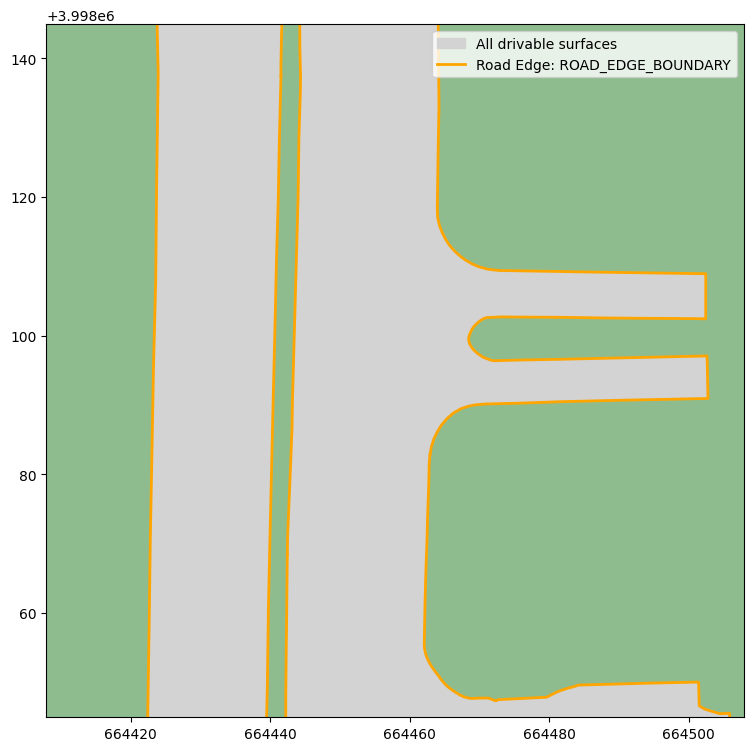

In [15]:
drivable_surface_layers = [
    MapLayer.LANE_GROUP,
    MapLayer.INTERSECTION,
    MapLayer.GENERIC_DRIVABLE,
    MapLayer.CARPARK,
]

road_edge_color_map = {
    RoadEdgeType.UNKNOWN: "red",
    RoadEdgeType.ROAD_EDGE_BOUNDARY: "orange",
    RoadEdgeType.ROAD_EDGE_MEDIAN: "blue",
}

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

for drivable_surface_layer in drivable_surface_layers:
    for drivable_surface_object in map_object_dict[drivable_surface_layer]:
        add_map_surface_object(
            ax,
            drivable_surface_object,
            label="All drivable surfaces",
            color="lightgrey",
            alpha=1.0,
            add_id=False,
            zorder=0,
        )

for road_edge in map_object_dict[MapLayer.ROAD_EDGE]:
    add_map_line_object(
        ax,
        road_edge,
        label=f"Road Edge: {road_edge.road_edge_type.name}",
        color=road_edge_color_map.get(road_edge.road_edge_type, "black"),
        linewidth=2.0,
        add_id=False,
        zorder=1,
    )

add_non_repeating_legend_to_ax(ax)
ax.set_xlim(query_point.x - query_radius / 2, query_point.x + query_radius / 2)
ax.set_ylim(query_point.y - query_radius / 2, query_point.y + query_radius / 2)

# Change background color to see the lines better
ax.set_facecolor("darkseagreen")
plt.show()

### 2.5.6 `RoadLine`

Road lines are lane markings that are in the map, either defined by a 3D or 2D polyline. A road line has a `RoadLineType`, which is one of:

In [16]:
for road_line_type in RoadLineType:
    print(f"- {road_line_type}")

- RoadLineType.NONE
- RoadLineType.UNKNOWN
- RoadLineType.DASH_SOLID_YELLOW
- RoadLineType.DASH_SOLID_WHITE
- RoadLineType.DASHED_WHITE
- RoadLineType.DASHED_YELLOW
- RoadLineType.DOUBLE_SOLID_YELLOW
- RoadLineType.DOUBLE_SOLID_WHITE
- RoadLineType.DOUBLE_DASH_YELLOW
- RoadLineType.DOUBLE_DASH_WHITE
- RoadLineType.SOLID_YELLOW
- RoadLineType.SOLID_WHITE
- RoadLineType.SOLID_DASH_WHITE
- RoadLineType.SOLID_DASH_YELLOW
- RoadLineType.SOLID_BLUE


In some datasets, the road line is equivalent to left/right boundaries. A lane can have various road lines along its boundaries, making referencing to lanes difficult. We currently include that as separate map objects.

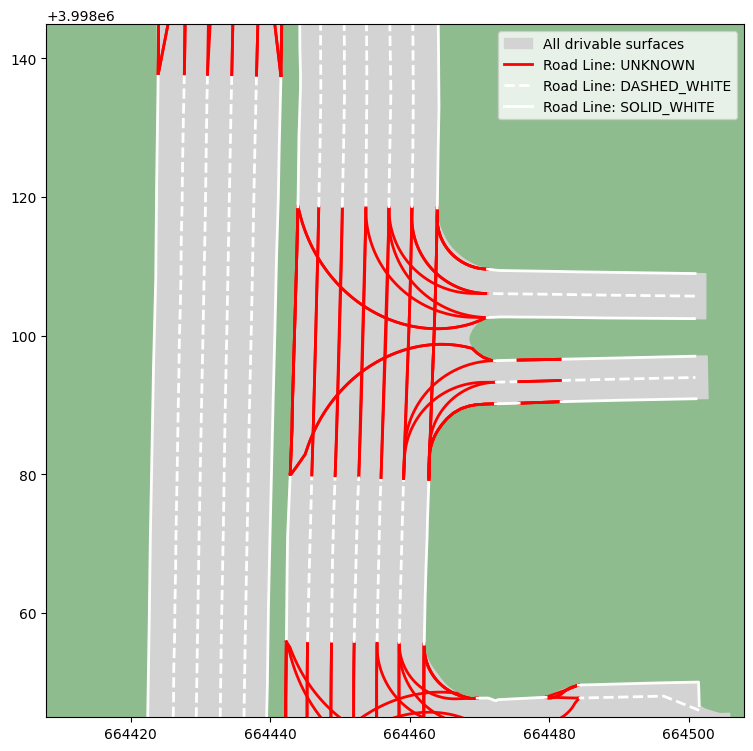

In [17]:
road_line_color_map = {
    RoadLineType.NONE: "grey",
    RoadLineType.UNKNOWN: "red",
    RoadLineType.DASH_SOLID_YELLOW: "yellow",
    RoadLineType.DASH_SOLID_WHITE: "white",
    RoadLineType.DASHED_WHITE: "white",
    RoadLineType.DASHED_YELLOW: "yellow",
    RoadLineType.DOUBLE_SOLID_YELLOW: "yellow",
    RoadLineType.DOUBLE_SOLID_WHITE: "white",
    RoadLineType.DOUBLE_DASH_YELLOW: "yellow",
    RoadLineType.DOUBLE_DASH_WHITE: "white",
    RoadLineType.SOLID_YELLOW: "yellow",
    RoadLineType.SOLID_WHITE: "white",
    RoadLineType.SOLID_DASH_WHITE: "white",
    RoadLineType.SOLID_DASH_YELLOW: "yellow",
    RoadLineType.SOLID_BLUE: "blue",
}

road_line_style_map = {
    RoadLineType.DASHED_WHITE: "--",
    RoadLineType.DASHED_YELLOW: "--",
    RoadLineType.DOUBLE_DASH_YELLOW: "--",
    RoadLineType.DOUBLE_DASH_WHITE: "--",
}

road_line_width_map = {
    RoadLineType.DOUBLE_SOLID_YELLOW: 3.0,
    RoadLineType.DOUBLE_SOLID_WHITE: 3.0,
    RoadLineType.DOUBLE_DASH_YELLOW: 3.0,
    RoadLineType.DOUBLE_DASH_WHITE: 3.0,
}

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

for drivable_surface_layer in drivable_surface_layers:
    for drivable_surface_object in map_object_dict[drivable_surface_layer]:
        add_map_surface_object(
            ax,
            drivable_surface_object,
            label="All drivable surfaces",
            color="lightgrey",
            alpha=1.0,
            add_id=False,
            zorder=0,
        )

for road_line in map_object_dict[MapLayer.ROAD_LINE]:
    line_color = road_line_color_map.get(road_line.road_line_type, "black")
    line_style = road_line_style_map.get(road_line.road_line_type, "-")
    line_width = road_line_width_map.get(road_line.road_line_type, 2.0)

    add_map_line_object(
        ax,
        road_line,
        label=f"Road Line: {road_line.road_line_type.name}",
        color=line_color,
        linestyle=line_style,
        linewidth=line_width,
        add_id=False,
        zorder=1,
    )

add_non_repeating_legend_to_ax(ax)
ax.set_xlim(query_point.x - query_radius / 2, query_point.x + query_radius / 2)
ax.set_ylim(query_point.y - query_radius / 2, query_point.y + query_radius / 2)

# Change background color to see the road lines better
ax.set_facecolor("darkseagreen")
plt.show()

You made it to end. You can repeat the tutorial for different datasets and filtering settings.